In [1]:
#imports
import skimage
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd 
import math
from skimage import filters
from skimage import feature 
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import slic, mark_boundaries

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def bgSubRGB(bg, im, T):
    # TODO: consider normalizing brightness to avoid selecting shadows
    bgR = bg[:,:,0]
    bgG = bg[:,:,1]
    bgB = bg[:,:,2]
    
    imR = im[:,:,0]
    imG = im[:,:,1]
    imB = im[:,:,2]
    # Euclidean distance (slide 8 of region detection HW)
    return ((imR - bgR) ** 2 + (imG - bgG) ** 2 + (imB - bgB) ** 2) > T ** 2

In [3]:
def close(im):
    structure=np.ones((3,3))
    im = ndimage.binary_dilation(im, structure)
    im = ndimage.binary_erosion(im, structure)
    return im

In [4]:
def open(im):
    structure=np.ones((3,3))
    im = ndimage.binary_erosion(im, structure)
    im = ndimage.binary_dilation(im, structure)
    return im

0  possible regions in image  1


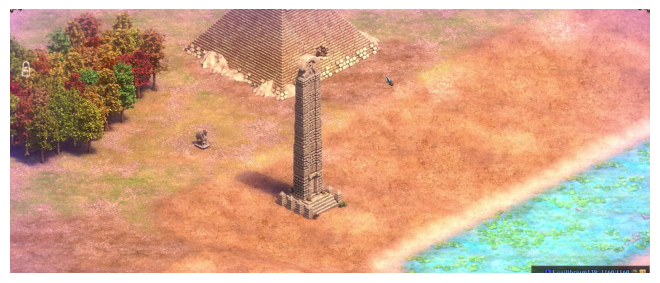

0  possible regions in image  2


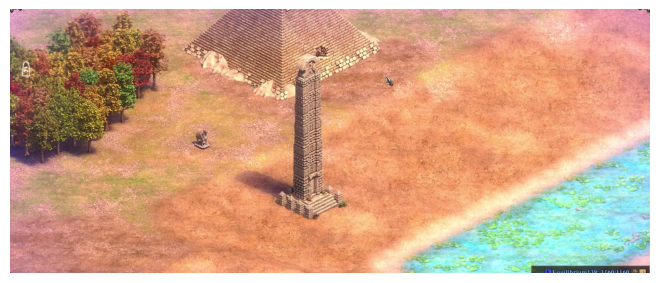

1  possible regions in image  3


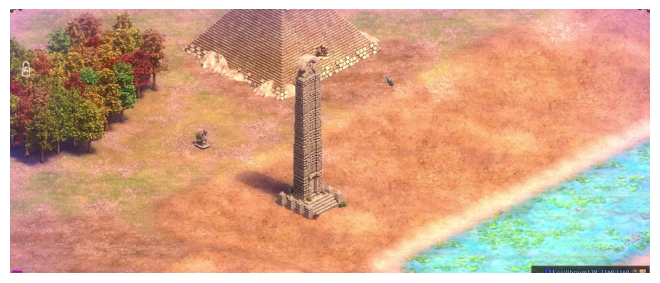

1  possible regions in image  4


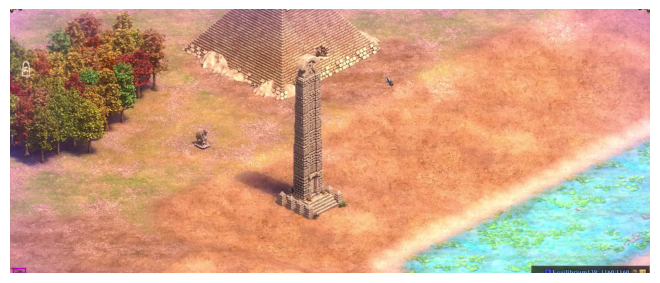

2  possible regions in image  5


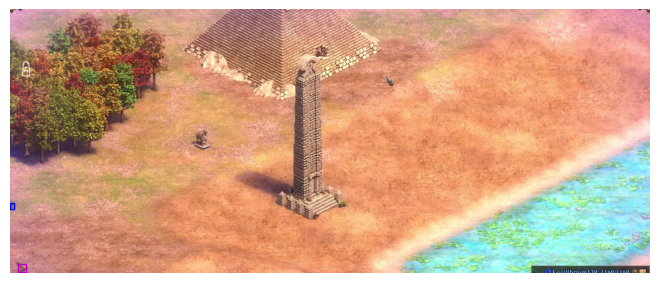

2  possible regions in image  6


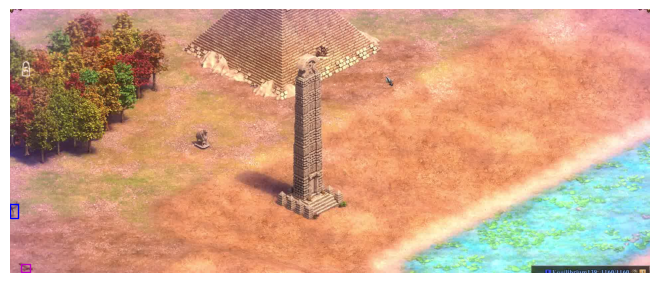

2  possible regions in image  7


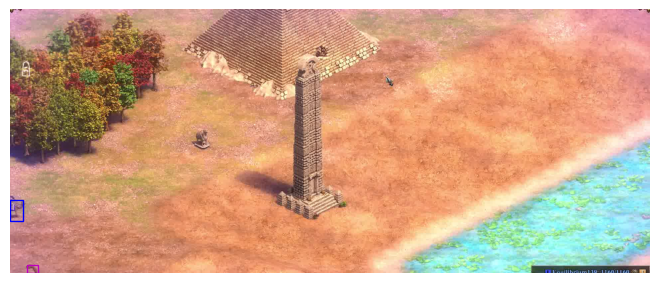

2  possible regions in image  8


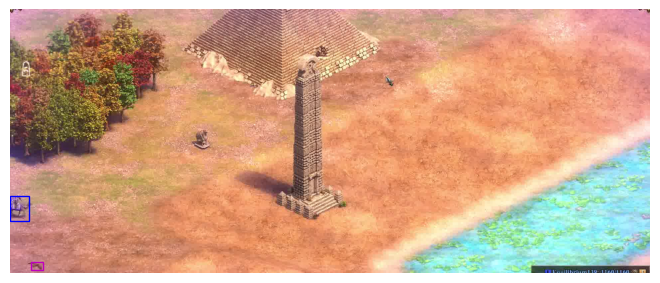

2  possible regions in image  9


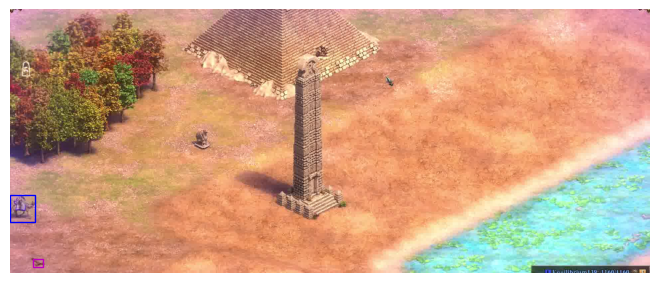

2  possible regions in image  10


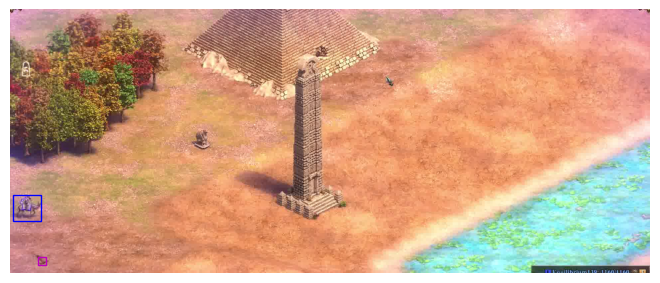

2  possible regions in image  11


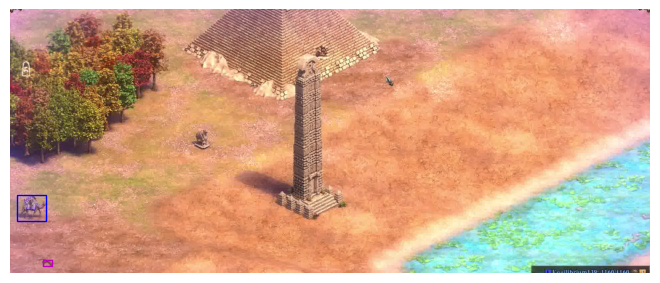

4  possible regions in image  12


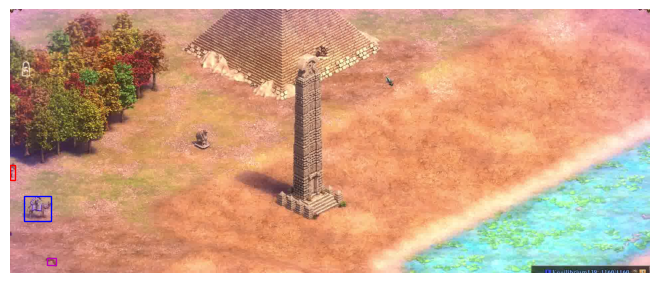

5  possible regions in image  13


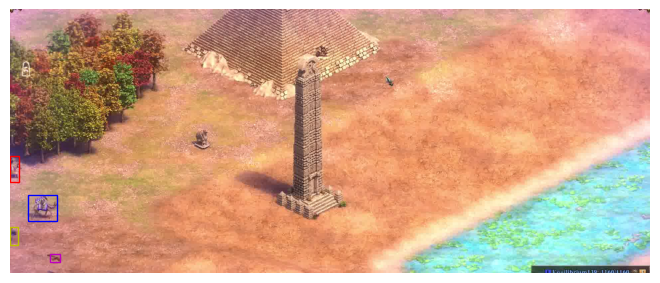

5  possible regions in image  14


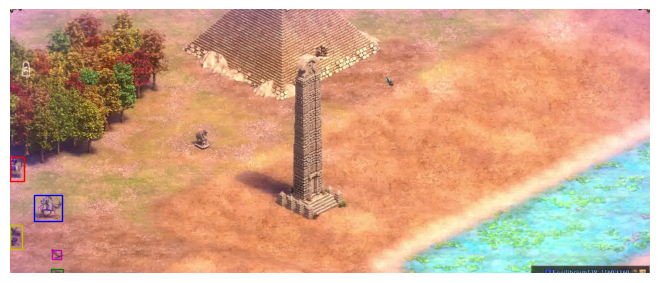

5  possible regions in image  15


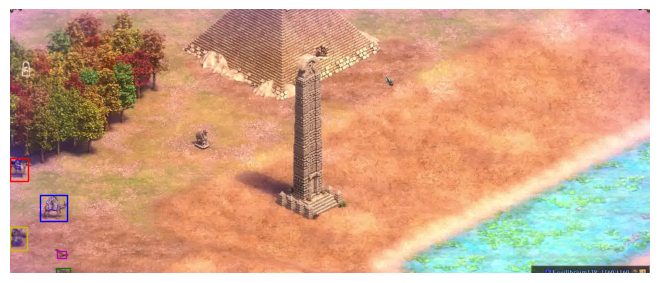

5  possible regions in image  16


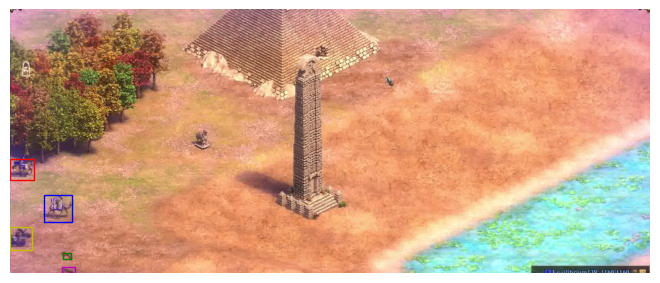

5  possible regions in image  17


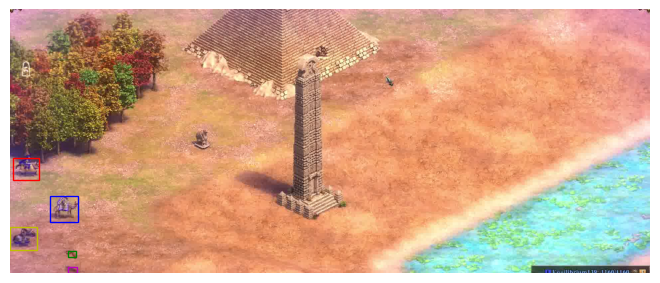

5  possible regions in image  18


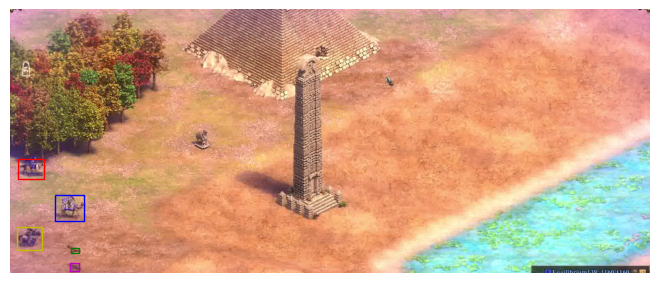

5  possible regions in image  19


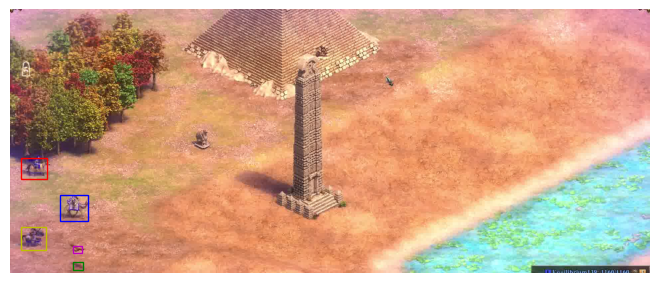

5  possible regions in image  20


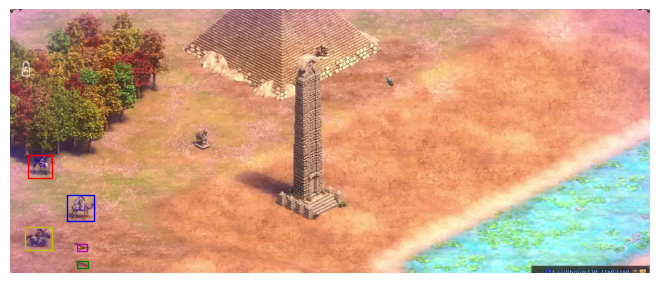

In [5]:
numFrames = 22
frames = np.array([io.imread('frames/frame (%d).jpg' % i) for i in range(1,numFrames)], dtype='float64')/255
T = 0.21
bg = frames[0]

#covariance models
maxRegions = 5
models = np.zeros((maxRegions, 5, 5))
numModels = 0

colors = ['m', 'b', 'r', 'y', 'g']
for i in range(1, len(frames)):
    diff = bgSubRGB(bg, frames[i], T)
    diff = open(diff)
    diff = skimage.filters.gaussian(diff, sigma=10)
    diff = diff > T
    labels = label(diff)
    regions = regionprops(labels)
    properties = regionprops_table(labels, diff, properties= \
                            ['bbox', 'area','convex_area','bbox_area'])
    print(len(regions), " possible regions in image ", i)
    #outlines = mark_boundaries(frames[i], labels)
    
    
    #############covariance tracking
    covariances = np.zeros((maxRegions, 5, 5))
    locations = np.zeros((maxRegions, 5))
    props = pd.DataFrame(properties)
    
    #we can use theseeep track of any regions that are too small
    regionCount = len(regions) 
    regionsBool = np.zeros((maxRegions)) #regionsBool[i] = 1 if it needs to be 
    regionsBool[0:len(regions)] = 1 #assigned to a model for this frame
    
    for index, region in props.iterrows():
        x = region['bbox-1']
        y = region['bbox-0']
        window = frames[i][region['bbox-1']:region['bbox-3'],region['bbox-0']:region['bbox-2']]
        locations[index] = [x, y, window.shape[0], window.shape[1], index]
        
        feature = np.zeros((5,window.shape[0]*window.shape[1]))
        for a in range(window.shape[0]):
            for b in range(window.shape[1]):
                feature[:, (a*window.shape[1] + b)] = np.array([a, b, window[a, b, 0], window[a, b, 1], window[a, b, 2]])
        
        cov = np.cov(feature, bias=True)
        covariances[index] = cov

    #assign each calculated covariance to a model
    orderedLocations = []
    for modelIndex in range(numModels):
        minDist = 100000000
        minIndex = -1
        for index in range(len(regions)):
            if regionsBool[index] == 1:
                #calculate distances
                eigW, eigV = sp.linalg.eig(models[modelIndex], covariances[index])
                isValid = True
                #make sure no infinite eigenvalue
                for value in eigW:
                    if math.isinf(value.real):
                        regionsBool[index] = 0
                        isValid = False
                      
                if isValid:
                    dist =  np.sqrt((np.log(eigW)**2).sum())
                    if dist < minDist:
                        minDist = dist
                        minIndex = index
                else:
                    regionCount -= 1
                    
        #store data about winning region
        regionsBool[minIndex] = 0
        models[modelIndex] = covariances[minIndex]
        orderedLocations.append(locations[minIndex])
        
    #if we have a new region
    if regionsBool.sum() > 0:
        for index in range(regionCount):
            if regionsBool[index] == 1:
                models[numModels] = covariances[index]
                orderedLocations.append(locations[index])
                numModels += 1
    
    #draw figures and save
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(frames[i])
    for index in range(regionCount):
        rect = patches.Rectangle((orderedLocations[index][0], orderedLocations[index][1]), orderedLocations[index][2], \
                                 orderedLocations[index][3], linewidth=1, edgecolor=colors[index], facecolor='none')
    
        ax.add_patch(rect)
    filename = 'outlines' + str(i) + '.jpg'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    #io.imsave(filename, (outlines*255).astype(np.uint8))